<a href="https://colab.research.google.com/github/Yannethtj/PruebasSaberProInteligenciaArtificial/blob/main/99_modelo_solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!kaggle
!chmod 600 ./kaggle.json

usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: the following arguments are required: command


In [2]:
!kaggle competitions download -c udea-ai4eng-20242

 70% 14.0M/20.1M [00:00<00:00, 54.1MB/s]
100% 20.1M/20.1M [00:00<00:00, 60.8MB/s]


In [3]:
!unzip udea-ai4eng-20242.zip


Archive:  udea-ai4eng-20242.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [4]:

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt




In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head().T

,0,1,2,3,4
ID,904256,645256,308367,470353,989032
PERIODO,20212,20212,20203,20195,20212
ESTU_PRGM_ACADEMICO,ENFERMERIA,DERECHO,MERCADEO Y PUBLICIDAD,ADMINISTRACION DE EMPRESAS,PSICOLOGIA
ESTU_PRGM_DEPARTAMENTO,BOGOTÁ,ATLANTICO,BOGOTÁ,SANTANDER,ANTIOQUIA
ESTU_VALORMATRICULAUNIVERSIDAD,Entre 5.5 millones y menos de 7 millones,Entre 2.5 millones y menos de 4 millones,Entre 2.5 millones y menos de 4 millones,Entre 4 millones y menos de 5.5 millones,Entre 2.5 millones y menos de 4 millones
ESTU_HORASSEMANATRABAJA,Menos de 10 horas,0,Más de 30 horas,0,Entre 21 y 30 horas
FAMI_ESTRATOVIVIENDA,Estrato 3,Estrato 3,Estrato 3,Estrato 4,Estrato 3
FAMI_TIENEINTERNET,Si,No,Si,Si,Si
FAMI_EDUCACIONPADRE,Técnica o tecnológica incompleta,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,No sabe,Primaria completa
FAMI_EDUCACIONMADRE,Postgrado,Técnica o tecnológica incompleta,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Primaria completa


In [6]:
def limpiar_y_preprocesar(data):

  data = data.drop('ID', axis=1)
  data['PERIODO'] = data['PERIODO'].astype(str).apply(lambda text: text[:4])
  def normalize_text(text: str):
    import unicodedata
    import re
    if not pd.isna(text):
        # Normaliza el texto eliminando acentos
        normalized = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
        # Elimina caracteres no deseados, incluidos "¿" y "?"
        return re.sub(r'[¿?]', '', normalized)
    return text

  def group_values_by_frequency(data: pd.DataFrame, col: str, thresholds: list[float] = [0.05, 0.2]):
    """
    Agrupa los valores de una columna en función de su frecuencia relativa.
    Los valores se agrupan en categorías basadas en una lista de umbrales.

    Args:
        data (pd.DataFrame): DataFrame de entrada.
        col (str): Nombre de la columna a procesar.
        thresholds (list[float]): Lista de umbrales para definir los grupos.

    Returns:
        pd.Series: Serie con los valores agrupados.
    """
    porcentaje = data[col].value_counts(normalize=True)

    def asignar_grupo(value):
        freq = porcentaje[value]
        for i, t in enumerate(thresholds):
            if freq < t:
                return f'GRUPO_{i+1}'
        return 'GRUPO_ALTO'

    return data[col].apply(asignar_grupo)


  for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']:
      data[col] = data[col].apply(normalize_text)
  for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']:
      data[col] = group_values_by_frequency(data, col)

  mapeo = {'Si': 1, 'S': 1, 'No': 0, 'N':0}
  target_columns = ['FAMI_TIENEINTERNET', 'ESTU_PAGOMATRICULAPROPIO']
  for column in target_columns:
      data[column] = data[column].map(mapeo)
  for col in target_columns:
    data[col] = data[col].fillna(0)

  mapeo_estrato = {'Sin Estrato': 0, 'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6}

  data['FAMI_ESTRATOVIVIENDA'] = data['FAMI_ESTRATOVIVIENDA'].map(mapeo_estrato)

  mode_value = data['FAMI_ESTRATOVIVIENDA'].mode()[0]


  data['FAMI_ESTRATOVIVIENDA'] = data['FAMI_ESTRATOVIVIENDA'].fillna(mode_value)

  variables_continuas = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

  mapeo_valores_matricula = {
      'Menos de 500 mil': 0,
      'Entre 500 mil y menos de 1 millón': 1,
      'Entre 1 millón y menos de 2.5 millones': 2,
      'Entre 2.5 millones y menos de 4 millones': 3,
      'Entre 4 millones y menos de 5.5 millones': 4,
      'Entre 5.5 millones y menos de 7 millones': 5,
      'Más de 7 millones': 6,
      'No pagó matrícula': 7
  }

  mapeo_valores_horas_trabajo = {
      '0': 0,
      'Menos de 10 horas': 1,
      'Entre 11 y 20 horas': 2,
      'Entre 21 y 30 horas': 3,
      'Más de 30 horas': 4
  }


  data['ESTU_VALORMATRICULAUNIVERSIDAD'] = data['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valores_matricula)
  data['ESTU_HORASSEMANATRABAJA'] = data['ESTU_HORASSEMANATRABAJA'].map(mapeo_valores_horas_trabajo)
  for col in variables_continuas:
    data[col] = data[col].fillna(0)

  moda_padre = data['FAMI_EDUCACIONPADRE'].mode()[0]
  moda_madre = data['FAMI_EDUCACIONMADRE'].mode()[0]


  data['FAMI_EDUCACIONPADRE'] = data['FAMI_EDUCACIONPADRE'].fillna(moda_padre)
  data['FAMI_EDUCACIONMADRE'] = data['FAMI_EDUCACIONMADRE'].fillna(moda_madre)
  data = pd.get_dummies(data, columns=[ 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE','ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO'], prefix=['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE','ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO'])
  data.replace({True: 1, False: 0})

  return data


In [7]:
dtr = train
dts = test
lentr = len(dtr)
dtr.shape, dts.shape

((692500, 12), (296786, 12))

In [8]:
source_cols = [i for i in dtr.columns if i!="RENDIMIENTO_GLOBAL"]
all_data = pd.concat((dtr[source_cols], dts[source_cols]))
all_data.index = range(len(all_data))
all_data = limpiar_y_preprocesar(all_data)

Xtrk, ytrk = all_data.iloc[:lentr].values, dtr["RENDIMIENTO_GLOBAL"].values
Xtsk  = all_data.iloc[lentr:].values

print (Xtrk.shape, ytrk.shape)
print (Xtsk.shape)

<ipython-input-6-c6c3e0ad0eb7>:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({True: 1, False: 0})


(692500, 35) (692500,)
(296786, 35)


In [9]:
n = int(len(Xtrk)*0.7)
n

484749

In [10]:
idxs = np.random.permutation(len(Xtrk))
idxs_trm = idxs[:n]
idxs_tsm = idxs[n:]

Xtrm = Xtrk[idxs_trm]
ytrm = ytrk[idxs_trm]

Xtsm = Xtrk[idxs_tsm]
ytsm = ytrk[idxs_tsm]

print (Xtrm.shape, ytrm.shape, Xtsm.shape, ytsm.shape)

(484749, 35) (484749,) (207751, 35) (207751,)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:27:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Precisión del modelo XGBoost: 0.4027321168129155

Reporte de clasificación:
              precision    recall  f1-score   support

        alto       0.50      0.59      0.54     52795
        bajo       0.41      0.54      0.47     51893
  medio-alto       0.31      0.22      0.25     51339
  medio-bajo       0.33      0.25      0.28     51724

    accuracy                           0.40    207751
   macro avg       0.39      0.40      0.39    207751
weighted avg       0.39      0.40      0.39    207751



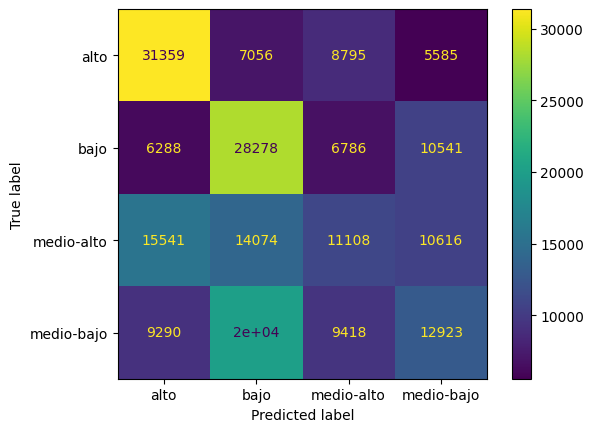

In [11]:

# Codificación de las etiquetas de salida
label_encoder = LabelEncoder()
label_encoder.fit(ytrm)  # Fit with training data labels (ytrm)

ytsm_encoded = label_encoder.transform(ytsm)
ytrm_encoded = label_encoder.transform(ytrm)

d_train = xgb.DMatrix(Xtrm, label=ytrm_encoded)
d_test = xgb.DMatrix(Xtsm, label=ytsm_encoded)

# Configuración básica del modelo XGBoost
params = {
    'objective': 'multi:softmax',        # Clasificación multiclase
    'num_class': len(label_encoder.classes_),  # Número de clases
    'eval_metric': 'merror',             # Métrica de error (error de clasificación)
    'max_depth': 6,                      # Profundidad máxima de los árboles
    'learning_rate': 0.1,                # Tasa de aprendizaje
    'subsample': 0.8,                    # Porcentaje de datos para cada árbol
    'colsample_bytree': 0.8,             # Proporción de características usadas
    'n_estimators': 100                  # Número de árboles
}

# Entrenar el modelo con XGBoost
modelo_xgb = xgb.train(params, d_train, num_boost_round=100)

# Predicción en conjunto de prueba
y_pred_proba = modelo_xgb.predict(d_test)

# Evaluar precisión
y_pred = y_pred_proba.astype(int)  # Asegúrate de que las predicciones sean enteros (clasificación multiclase)
print("Precisión del modelo XGBoost:", accuracy_score(ytsm_encoded, y_pred))

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(ytsm_encoded, y_pred, target_names=label_encoder.classes_))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(ytsm_encoded, y_pred, display_labels=label_encoder.classes_)
